# Sequence+v1.0

**Goal**: Build a model that can predict the total run value for any given *two* pitch sequence<br>
**Author**: Jensen Holm <br>
**Date**: October / November 2024

In [1]:
import statcast_pitches
import polars as pl
import polars.selectors as cs
import numpy as np
from plotnine import *
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches)

In [2]:
# use statcast pitches to get all pitches thrown in since hawkeye began
pitches_lf: pl.LazyFrame = (statcast_pitches.load()
                            .filter(pl.col("game_date").dt.year() >= 2024))

latest_date = pitches_lf.select("game_date").max().collect().item().date()
earliest_date = pitches_lf.select("game_date").min().collect().item().date()
n_pitches = pitches_lf.select(pl.len()).collect().item()

print(f"N Pitches: {n_pitches}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 761176
Date Range: 2024-03-15 - 2024-10-30


In [3]:
run_values_24 = pl.scan_csv(
    # os.path.join(DATA_DIR, "run_values.csv")
    "https://raw.githubusercontent.com/Jensen-holm/Sequence-Plus/refs/heads/main/data/run_values.csv"
).rename({"event": "events"}) # it is called 'events' in pitches_df

# Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`|
| **x_0.120** | position in the x dimension of the pitch at decision time (~0.12s) |
| **y_0.120** | position in the y dimension of the pitch at decision time (~0.12s) |
| **z_0.120** | position in the z dimension of the pitch at decision time (~0.12s) |
| **x_0.167** | position in the x dimension of the pitch at commit time (~0.167s) |
| **y_0.167** | position in the y dimension of the pitch at commit time (~0.167s) |
| **z_0.167** | position in the z dimension of the pitch at commit time (~0.167s) |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |
| **3d_dist_0.167** | 3D euclidean distance between pitches in a two pitch sequence 0.167 seconds after release |
| **3d_dist_0.120** | 3D distance between pitches in a two pitch sequence at 0.120 seconds after release |
| **distance** | 2D euclidean distance between pitch locations when crossing the plate in a two pitch sequence |
| **seq_delta_run_exp** | sum of `delta_run_exp` in a two pitch sequence |
| **plate_x_diff** | difference in plate_x between pitches in a two pitch sequence |
| **plate_z_diff** | difference in plate_z between pitches in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

## Expected Run Value

Joining the expected runs from run_values_24 to the pitches dataframe so that each pitch has an associated run value.

**New Features**

- `delta_run_exp`

In [4]:

description_replace_mapping = {
    "Ball": "ball",
    "In play, run(s)": "hit_into_play",
    "In play, out(s)": "hit_into_play",
    "In play, no out": "hit_into_play",
    "Called Strike": "called_strike",
    "Foul": "foul",
    "Swinging Strike": "swinging_strike",
    "Blocked Ball": "ball",
    "Swinging Strike (Blocked)": "swinging_strike",
    "Foul Tip": "swinging_strike",
    "Foul Bunt": "foul",
    "Hit By Pitch": "hit_by_pitch",
    "Pitchout": "ball",
    "Missed Bunt": "swinging_strike",
    "Bunt Foul Tip": "swinging_strike",
    "Foul Pitchout": "foul",
    "Ball In Dirt": "ball",
}

def add_pitch_run_value(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Takes in a dataframe of pitches, and adds 2024 run value to each one"""
    pitch_runs_lf = lf.join(
        other=run_values_24,
        on=["events", "balls", "strikes"],
        how="left",
    )

    mapped_des_pitches = pitch_runs_lf.with_columns([
        pl.col("description")
        .replace_strict(description_replace_mapping, default=None)
        .alias("play_des"),
    ])

    pitches_run_value_lf = mapped_des_pitches.join(
        other=run_values_24,
        right_on=["events", "balls", "strikes"],
        left_on=["play_des", "balls", "strikes"],
        how="left",
        suffix="_des",
    ).with_columns([
        pl.when(pl.col("delta_run_exp").is_null())
        .then(pl.col("delta_run_exp_des"))
        .otherwise(pl.col("delta_run_exp"))
        .alias("delta_run_exp"),
    ])
    return pitches_run_value_lf

pitches_run_value_lf = pitches_lf.pipe(add_pitch_run_value)
pitches_run_value_lf.select(
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
).describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""747483""","""761176""",761176.0,761176.0,725703.0
"""null_count""","""13693""","""0""",0.0,0.0,35473.0
"""mean""",null,null,0.867148,0.901089,0.000023
"""std""",null,null,0.965891,0.829563,0.239968
"""min""","""CH""","""ball""",0.0,0.0,-1.463
"""25%""",null,null,0.0,0.0,-0.067
"""50%""",null,null,1.0,1.0,-0.016
"""75%""",null,null,1.0,2.0,0.035
"""max""","""SV""","""swinging_strike_blocked""",4.0,2.0,3.525


In order to keep it simple, I am mirroring the movement and the horizontal release position of each pitch thrown from LHP, to as if it were thrown by RHP.

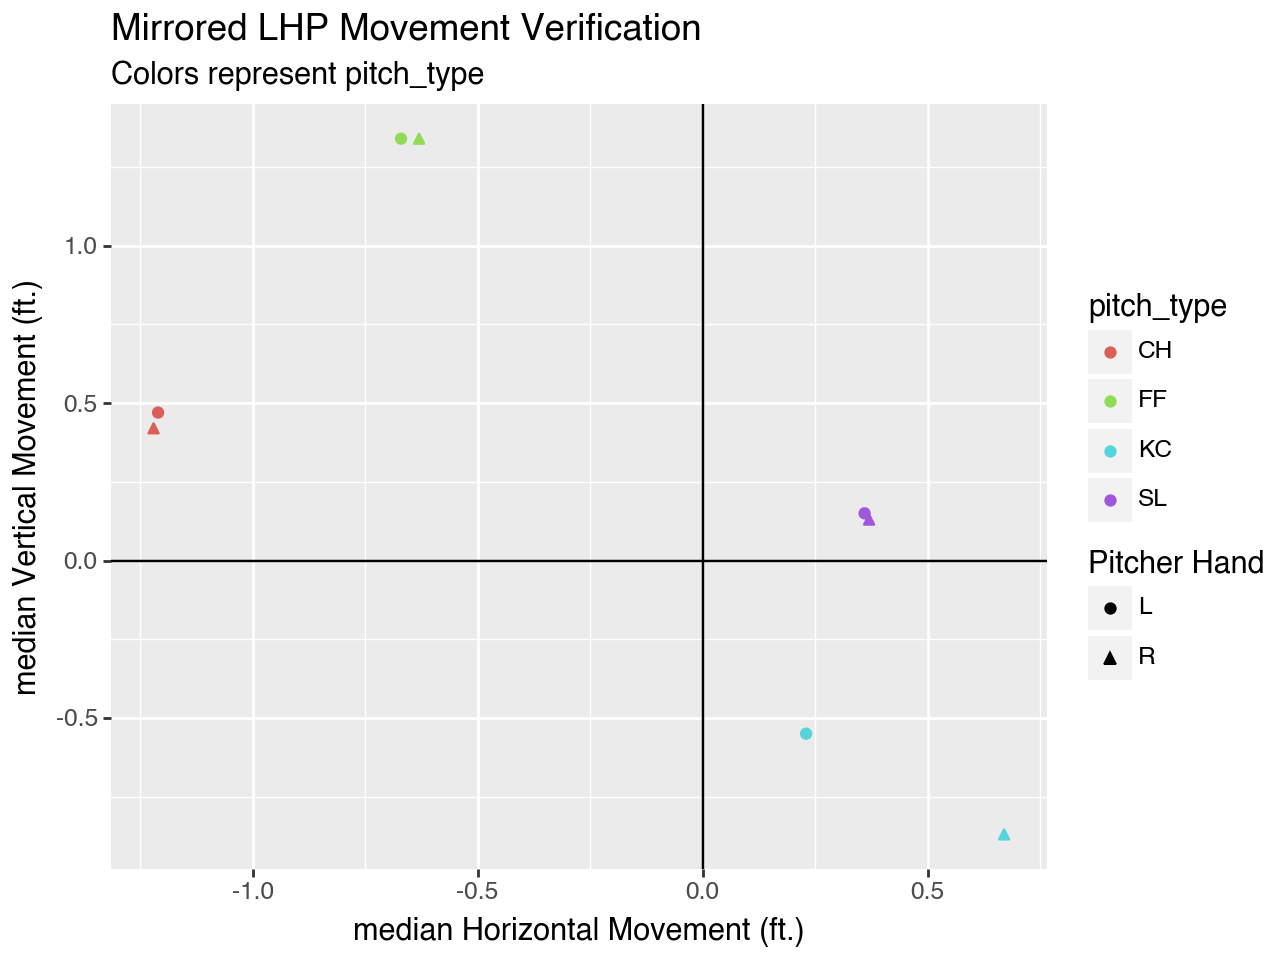

In [5]:
def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),

        # also mirror the horizontal release point
        # (release_pos_x is from catcher perspective)
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("release_pos_x"))
        .otherwise(pl.col("release_pos_x")),
    )

mirrored_pitches_lf = pitches_run_value_lf.pipe(mirror_lhp_to_rhp)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_lf
        .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").median().alias("median_pfx_x"),
            pl.col("pfx_z").median().alias("median_pfx_z"),
        ).collect(),
        aes(x="median_pfx_x", y="median_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement Verification",
        x="median Horizontal Movement (ft.)",
        y="median Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!

## 3D Pitch Location Estimation

Now to add ball positions in 3D space at both [decision time]() (0.12s) & [commit time]() (0.167s)

### Step 1: Time to 50ft. from home plate

Estimate the time it took the baseball to travel from release point to 50ft from home plate (the point where we have measurements for a &v in x, y, z dimensions)

$t_{50} = \frac{(60 + 6/12) - 50 - extension}{vft * 1.05}$

Where ...
- $extension = $ distance from the rubber where the pitch was released<br>
- $vft = $ release_speed in ft/s

I multiply the velocity by 1.05 in order to dialate the time by 5%. This makes our estimation of position more accurate because it helps account for error that we get from assuming that acceleration is constant in the kinematic equations for displacement.

**New Features**
- `t50`: estimated time it took the ball to get to 50ft. from home plate
- `release_pos_y`: release position in the y dimension converted to feet


In [6]:
def displacement(p0, v0, t, a):
    return p0 + v0 * t + 0.5 * a * t**2

def convert_release_y_to_ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(pl.col("release_pos_y") / 12)

def estimate_time_to_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        ((((60 + 6/12) - 50) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t50")
    )

time_to_50ft_lf = (mirrored_pitches_lf
                   .pipe(convert_release_y_to_ft)
                   .pipe(estimate_time_to_50ft))

(time_to_50ft_lf
    .select("release_pos_y", "t50")
    .describe())

statistic,release_pos_y,t50
str,f64,f64
"""count""",746281.0,745450.0
"""null_count""",14895.0,15726.0
"""mean""",4.50379,0.029637
"""std""",0.038004,0.004399
"""min""",4.313333,0.012265
"""25%""",4.48,0.026799
"""50%""",4.5025,0.029316
"""75%""",4.528333,0.032118
"""max""",4.775833,0.136384


### Step 2: x, y, & z positions at 50ft. from home plate

For this I use the kinematic equations with the acceleration, velocity and now our time estimate, $t_{50}$, to calculate displacement in each dimension.

$d_{50} = r_{dim} + v_{dim} * t_{50} * \frac{1}{2} * a_{dim} * t_{50}^2$

Where ...
- $r_{dim} = $ release position in x, y or z dimension
- $v_{dim} = $ velocity at 50ft. from home plate in x, y or z dimension
- $a_{dim} = $ acceleration at 50ft. from home plate in x, y or z dimension
- $t_{50} = $ estimated time that it took to get to 50ft. from home plate from step 1

**New Features**
- `x50`: position in the x dimension when the ball is 50ft. from home plate
- `y50`: position in the y dimension when the ball is 50ft. from home plate
- `z50`: position in the z dimension when the ball is 50ft. from home plate


In [7]:
def estimate_pos_at_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"release_pos_{d}"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t50"),
        ).alias(f"{d}50")
        for d in ["x", "y", "z"]
    )

pos_at_50ft_lf = time_to_50ft_lf.pipe(estimate_pos_at_50ft)

(pos_at_50ft_lf
    .select("x50", "y50", "z50")
    .describe())

statistic,x50,y50,z50
str,f64,f64,f64
"""count""",745450.0,745450.0,745450.0
"""null_count""",15726.0,15726.0,15726.0
"""mean""",-1.841894,0.69484,5.641312
"""std""",0.750444,0.391589,0.491664
"""min""",-5.027341,-1.990811,1.036836
"""25%""",-2.304915,0.469149,5.381889
"""50%""",-1.799675,0.72818,5.67098
"""75%""",-1.314786,0.915064,5.945786
"""max""",1.349322,2.622332,9.137442


### Step 3: Estimate 3D positions at commit time & decision time

Now we can make an estimate of where the ball is in all dimensions, at any given time. But I am interested specifically in 0.120 seconds after release (commit time), and 0.167 seconds after release (decision time).

For this I use the same formula that I used to esimate position at 50ft. from home plate, except I start from that 50ft. mark by calculating the difference in time between $t_{50}$ and $t_{i}$.

$d_{i} = p_{50} + v_{50} * (t_{50} - t_{i}) * \frac{1}{2} * a_{50} * (t_{50} - t_{i})^2$

Where ...
- $p_{50} = $ position in x, y, or z dimension at 50 ft. from home plate

I am assuming that both $v$ and $a$ are constant, again using a 5% time dilation as a crutch to help account for this.

**New Features**
- `x_0.120`: position in the x dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the y dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the z dimension at 0.120 seconds after release (commit time)
- `x_0.167`: position in the x dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the y dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the z dimension at 0.120 seconds after release (decision time)
- `t_plate`: estimated time that it takes the ball to reach home plate
- `x_plate`: position in the x dimension when the ball crossed the plate
- `y_plate`: position in the y dimension when the ball crossed the plate
- `z_plate`: position in the z dimension when the ball crossed the plate


In [8]:
def estimate_time_to_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        (((60 + 6/12) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t_plate")
    )

def estimate_ball_pos_at_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t_plate") - pl.col("t50"),
        ).alias(f"{d}_plate")
        for d in ["x", "y", "z"]
    )

def estimate_ball_pos_at_t(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=t - pl.col("t50"),
        ).alias(f"{d}_{t:.3f}")
        for d in ["x", "y", "z"]
        for t in times
    )

TIMES = [0.120, 0.167]

ball_pos_lf = (pos_at_50ft_lf
               .pipe(estimate_time_to_plate)
               .pipe(estimate_ball_pos_at_plate)
               .pipe(estimate_ball_pos_at_t, TIMES))

(ball_pos_lf
    .select("t50", "x_0.120", "y_0.120", "z_0.120",
            "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate")
    .describe())

statistic,t50,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,x_plate,y_plate,z_plate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0
"""null_count""",15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0
"""mean""",0.029637,-1.627299,-10.936196,5.204777,-1.523965,-16.886659,4.901972,-1.080414,-44.741142,2.635362
"""std""",0.004399,0.983568,1.025537,0.472491,1.155276,1.411775,0.507478,2.051601,0.437697,0.885576
"""min""",0.012265,-6.60534,-13.681389,1.381013,-7.414727,-20.63631,1.431101,-11.012415,-57.228537,-6.206166
"""25%""",0.026799,-2.063213,-11.759901,4.910474,-1.958383,-18.021553,4.570639,-1.797597,-45.020221,2.05403
"""50%""",0.029316,-1.420893,-11.088943,5.197198,-1.215323,-17.098705,4.883972,-0.393946,-44.734685,2.636855
"""75%""",0.032118,-0.953703,-10.206092,5.497094,-0.744161,-15.88191,5.215215,0.284999,-44.456599,3.219887
"""max""",0.136384,1.694922,-0.481725,8.93593,1.940703,-2.532972,9.571308,8.951553,-39.457035,12.055414


### Pitch Location Visualization

In order to make sure this is working, here I make a 3D scatter plot of 3 random pitches thrown by Yu Darvish in the 2024 season and their estimated positions at release, 50ft from home, commit time, decision time, and across the plate.

**Plot Line Color Legend**
- `Sweeper`: Purple
- `Splitter`: Yellow
- `Slider`: Green
- `Knuckle Curve`: Blue
- `Four Seam Fastball`: Red


In [9]:
pitch_types = ["KC", "FF", "FS", "SL", "ST"]
cols = ["pitch_type", "release_pos_x", "release_pos_y", "release_pos_z",
        "x50", "y50", "z50", "x_0.120", "y_0.120", "z_0.120",
        "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate"]

extra_times = np.arange(0, 0.5, 0.05).tolist()
extra_time_cols = [f"{d}_{t:.3f}"
                   for d in ["x", "y", "z"]
                   for t in extra_times]

# for the visualization, I am going to use a lot more time intervals
# for position estimation to get a smoother curve
sample_pitch_df = (ball_pos_lf
                   .filter(pl.col("game_date").dt.year() == 2024)
                   .filter(pl.col("pitch_type").is_in(pitch_types))
                   .filter(pl.col("player_name") == "Darvish, Yu")
                   .pipe(estimate_ball_pos_at_t, extra_times)
                   .drop_nulls(cols + extra_time_cols)
                   .group_by("pitch_type")
                   .agg(pl.col("*").sample(1, seed=40))
                   .select(cols + extra_time_cols)
                   .explode([pl.col(col)
                             for col in (cols + extra_time_cols)
                             if col != "pitch_type"])
                   .collect())


fig = px.scatter_3d()
colors = {"KC": "blue", "FF": "red", "FS": "yellow", "SL": "green", "ST": "purple"}
for pitch in sample_pitch_df.iter_rows(named=True):
    pitch_fig = px.line_3d(
        x=[pitch["release_pos_x"]] + [pitch[f"x_{t:.3f}"] for t in extra_times],
        y=[pitch["release_pos_y"]] + [pitch[f"y_{t:.3f}"] for t in extra_times],
        z=[pitch["release_pos_z"]] + [pitch[f"z_{t:.3f}"] for t in extra_times],
    )

    pitch_fig.update_traces(line=dict(color=colors[pitch["pitch_type"]]))
    fig.add_traces(pitch_fig.data)

fig.update_layout(title=dict(text="Random Yu Darvish Pitch Location Estimation"), showlegend=True)
fig.show()

## Location Estimation Error

Since I have the ground truth for release position, I can measure roughly how accurate the position estimation functions are by trying to estimate this release position in 3D space. I compute the mean euclidean distance between estimated release position and actual release position.

$3Deuclideandistance = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}$

Looking at the results, depending on the pitch type, it is typically off by anywhere between .4 inches and .8 inches on average.

**New Features**
- `approx_release_pos_x`: approximated release position in the x dimension working back from 50ft.
- `approx_release_pos_y`: approximated release position in the y dimension working back from 50ft.
- `approx_release_pos_z`: approximated release position in the z dimension working back from 50ft.


In [10]:
def estimate_release_pos(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=-pl.col("t50"),
        ).alias(f"approx_release_pos_{d}")
        for d in ["x", "y", "z"]
    )

ball_pos_lf = ball_pos_lf.pipe(estimate_release_pos)


def euclidean_distance(*pts):
    return sum((pt[0] - pt[1]) ** 2 for pt in pts) ** 0.5


(ball_pos_lf
    .drop_nulls([col for col in ball_pos_lf.collect_schema().names() if "release" in col])
    .select("release_pos_x", "release_pos_y", "release_pos_z",
            "approx_release_pos_x", "approx_release_pos_y", "approx_release_pos_z",
            "pitch_type")
    .filter(pl.col("pitch_type").is_in(pitch_types))
    .group_by("pitch_type")
    .agg(
        (euclidean_distance(
            *[(pl.col(f"approx_release_pos_{d}"), pl.col(f"release_pos_{d}"))
            for d in ["x", "y", "z"]]
        ).mean() * 12).alias("mean_euclidean_error_in.")
    )
    .collect())

pitch_type,mean_euclidean_error_in.
str,f64
"""FS""",0.438919
"""KC""",0.591464
"""ST""",0.527257
"""SL""",0.458928
"""FF""",0.323073


## Sequence Features

**New Feautres**

Everything in the `prev_features` list will be added, I don't want to type all of that out.

**Note**

May or may not need this depending on what sort of model I end up building

In [11]:
# features that we are interested in with regards to two pitch sequences
prev_features = [
    "prev_pfx_x",
    "prev_pfx_z",
    "prev_x_0.120",
    "prev_y_0.120",
    "prev_z_0.120",
    "prev_x_0.167",
    "prev_y_0.167",
    "prev_z_0.167",
    "prev_release_pos_x",
    "prev_release_pos_y",
    "prev_release_pos_z",
    "prev_release_speed",
    "prev_effective_speed",
    "prev_release_spin_rate",
    "prev_delta_run_exp",
    "prev_x_plate",
    "prev_y_plate",
    "prev_z_plate",
    "prev_pitch_type",
    "prev_zone",
]

def two_pitch_sequences(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    # sort the data such that the pitches are in descending order
    sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
    sorted_lf = lf.sort(
        by=sort_cols,
        descending=[True] * len(sort_cols),
    )

    return (sorted_lf
        .with_columns([
            pl.col(feature)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{feature}")
            for feature in [f.replace("prev_", "") for f in seq_features]
        ])
        .select(*sort_cols + seq_features)
        .join(other=lf, on=sort_cols, how="right")
    )

sequence_pitches_lf = (ball_pos_lf
                       .pipe(two_pitch_sequences, prev_features))

(sequence_pitches_lf
    .select(prev_features)
    .describe())

statistic,prev_pfx_x,prev_pfx_z,prev_x_0.120,prev_y_0.120,prev_z_0.120,prev_x_0.167,prev_y_0.167,prev_z_0.167,prev_release_pos_x,prev_release_pos_y,prev_release_pos_z,prev_release_speed,prev_effective_speed,prev_release_spin_rate,prev_delta_run_exp,prev_x_plate,prev_y_plate,prev_z_plate,prev_pitch_type,prev_zone
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""count""",719505.0,719505.0,718670.0,718670.0,718670.0,718670.0,718670.0,718670.0,719505.0,719505.0,719505.0,719504.0,718394.0,716174.0,700583.0,718670.0,718670.0,718670.0,"""720621""",719505.0
"""null_count""",54371.0,54371.0,55206.0,55206.0,55206.0,55206.0,55206.0,55206.0,54371.0,54371.0,54371.0,54372.0,55482.0,57702.0,73293.0,55206.0,55206.0,55206.0,"""53255""",54371.0
"""mean""",-0.32298,0.587488,-1.625712,-10.940308,5.20347,-1.521916,-16.892136,4.900503,-1.909632,4.50363,5.757664,89.194393,89.453109,2260.00459,-0.001664,-1.074505,-44.736599,2.634385,null,9.099955
"""std""",0.844157,0.711332,0.98577,1.02054,0.474191,1.157832,1.405036,0.509534,0.737582,0.037804,0.529617,5.952991,6.108701,362.574929,0.217474,2.056139,0.436359,0.894769,null,4.242454
"""min""",-2.25,-2.45,-6.60534,-13.681389,1.381013,-7.414727,-20.617553,1.431101,-4.73,4.313333,0.78,32.3,30.0,9.0,-1.463,-11.012415,-57.228537,-6.206166,"""CH""",1.0
"""25%""",-1.04,0.13,-2.061859,-11.764303,4.908474,-1.955111,-18.027337,4.567328,-2.39,4.479167,5.49,84.9,85.1,2107.0,-0.061,-1.779728,-45.016126,2.04301,null,5.0
"""50%""",-0.49,0.63,-1.418204,-11.094124,5.196363,-1.212666,-17.105208,4.883152,-1.88,4.5025,5.8,90.1,90.4,2291.0,-0.016,-0.393239,-44.73118,2.635908,null,11.0
"""75%""",0.33,1.2,-0.950297,-10.208015,5.498012,-0.74134,-15.884456,5.216917,-1.39,4.528333,6.08,94.0,94.3,2470.0,0.034,0.295369,-44.452188,3.228116,null,13.0
"""max""",2.95,2.31,1.694922,-0.498532,8.93593,1.940703,-2.556452,9.571308,1.18,4.768333,8.05,105.1,107.1,3578.0,3.525,8.951553,-39.457035,12.055414,"""SV""",14.0


## Adding 'diff' Features

**New Features**

For every feature in `prev_features`, we simply measure the difference in that feature between each pitch in a sequence. Each diff feature is its original name post fixed with 'diff'. Ex: `x_0.120_diff`, `y_0.120_diff` etc ...

In [12]:
def add_diff_features(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    num_seq_features = set(lf
                           .select(seq_features)
                           .select(cs.numeric())
                           .collect_schema()
                           .names())

    return lf.with_columns(
        (pl.col(feature.replace("prev_", ""))
        - pl.col(feature)).alias(f"{feature.replace('prev_', '')}_diff")
        for feature in num_seq_features
    )

sequence_diff_pitches_lf = sequence_pitches_lf.pipe(add_diff_features, prev_features)

diff_features = [
    col for col in (sequence_diff_pitches_lf
                    .collect_schema().names())
    if col.endswith("_diff")
]

(sequence_diff_pitches_lf
    .select(*diff_features)
    .describe())

statistic,release_speed_diff,effective_speed_diff,x_plate_diff,z_0.167_diff,zone_diff,pfx_x_diff,release_pos_z_diff,pfx_z_diff,release_spin_rate_diff,x_0.167_diff,y_plate_diff,release_pos_x_diff,z_plate_diff,y_0.120_diff,x_0.120_diff,z_0.120_diff,y_0.167_diff,delta_run_exp_diff,release_pos_y_diff
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",719290.0,717669.0,718216.0,718216.0,719292.0,719292.0,719292.0,719292.0,715065.0,718216.0,718216.0,719292.0,718216.0,718216.0,718216.0,718216.0,718216.0,700530.0,719292.0
"""null_count""",54586.0,56207.0,55660.0,55660.0,54584.0,54584.0,54584.0,54584.0,58811.0,55660.0,55660.0,54584.0,55660.0,55660.0,55660.0,55660.0,55660.0,73346.0,54584.0
"""mean""",0.007352,0.009398,-0.000118,-0.001812,-0.045406,-0.001395,-0.001758,-0.002318,-0.925466,0.000723,-0.001046,0.001232,-0.002714,-0.001463,0.00087,-0.001715,-0.002048,0.001611,-0.00001
"""std""",7.201021,7.30368,1.023022,0.539469,5.94883,1.063384,0.15777,0.905873,398.277452,0.50811,0.272631,0.215934,1.200048,1.230314,0.408608,0.413118,1.695191,0.322031,0.017145
"""min""",-50.5,-53.3,-9.390767,-4.24729,-13.0,-4.1,-3.35,-3.61,-2807.0,-3.866387,-12.429186,-2.96,-9.022921,-10.759134,-3.485634,-3.887295,-14.847905,-3.564,-0.211667
"""25%""",-4.4,-4.3,-0.670319,-0.34436,-4.0,-0.51,-0.08,-0.44,-140.0,-0.323741,-0.16435,-0.11,-0.782799,-0.737199,-0.25571,-0.2622,-1.013926,-0.099,-0.009167
"""50%""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""75%""",4.3,4.3,0.670959,0.34155,4.0,0.52,0.08,0.44,141.0,0.3254,0.163748,0.12,0.773523,0.741235,0.258206,0.259527,1.019839,0.086,0.009167
"""max""",60.6,63.1,8.667766,4.181905,13.0,4.29,2.8,3.67,2794.0,3.545338,11.138491,2.8,12.003925,9.041928,3.341437,3.502161,12.493472,3.781,0.255


## 3D distance features

Using the euclidean distance function from earlier, I can create features that represent the distance between a pitch, and the previous pitch thrown in any given two pitch sequence.

In [13]:
def add_3D_distances(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        # distance over the plate
        euclidean_distance(
            *[(pl.col(f"{d}_plate"), pl.col(f"prev_{d}_plate"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_plate"),

        # distance at release
        euclidean_distance(
            *[(pl.col(f"release_pos_{d}"), pl.col(f"prev_release_pos_{d}"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_release"),

        # distances at given times after release
        *[euclidean_distance(
            *[(pl.col(f"{d}_{t:.3f}"), pl.col(f"prev_{d}_{t:.3f}"))
             for d in ["x", "y", "z"]]
        ).alias(f"3d_dist_{t:.3f}")
        for t in times]
    )

sequence_dist_pitches_lf = sequence_diff_pitches_lf.pipe(add_3D_distances, TIMES)

(sequence_dist_pitches_lf
    .select("3d_dist_0.120", "3d_dist_0.167",
            "3d_dist_plate", "3d_dist_release")
    .describe())

statistic,3d_dist_0.120,3d_dist_0.167,3d_dist_plate,3d_dist_release
str,f64,f64,f64,f64
"""count""",718216.0,718216.0,718216.0,719292.0
"""null_count""",55660.0,55660.0,55660.0,54584.0
"""mean""",1.122686,1.521045,1.395168,0.210029
"""std""",0.768687,1.053233,0.783919,0.166448
"""min""",0.0,0.0,0.0,0.0
"""25%""",0.474485,0.631946,0.823798,0.09852
"""50%""",0.963878,1.294333,1.280892,0.170204
"""75%""",1.658248,2.25841,1.845021,0.2775
"""max""",11.017295,15.136046,13.018015,3.433369


# Serializing the LazyFrame w/ Features

This will allow me to pick up at this point in a new notebook if I want to

In [14]:
import os

DATA_DIR = os.path.join("..", "data")

sequence_dist_pitches_lf.serialize(
    os.path.join(DATA_DIR, "two_pitch_seqs_lf")
)

ball_pos_lf.serialize(
    os.path.join(DATA_DIR, "ball_pos_lf")
)

## Pre Processing

- Splitting data into training & test splits 
- Standard Scalar Normalization

In [15]:
features = [
    "release_speed", "release_pos_x", "release_pos_y", "release_pos_z",
    "3d_dist_plate", "3d_dist_release", "3d_dist_0.120", "3d_dist_0.167",
    "ax", "ay", "az", "vx0", "vy0", "vz0", "x50", "y50", "z50", "plate_x",
    "plate_z", "x_plate", "y_plate", "z_plate", "x_0.120", "y_0.120", "z_0.120",
    "x_0.167", "y_0.167", "z_0.167", "pitch_type", "zone", 
] + prev_features + diff_features

RESPONSE = "seq_delta_run_exp"

two_seqs_df = (sequence_dist_pitches_lf
               .with_columns((pl.col("delta_run_exp") 
                              + pl.col("prev_delta_run_exp"))
                              .alias(RESPONSE))
               .select(*features, RESPONSE)
               .drop_nulls()
               .collect()
               .to_dummies([
                   "pitch_type", 
                   "prev_pitch_type",
               ]))

two_seqs_df.describe()

statistic,release_speed,release_pos_x,release_pos_y,release_pos_z,3d_dist_plate,3d_dist_release,3d_dist_0.120,3d_dist_0.167,ax,ay,az,vx0,vy0,vz0,x50,y50,z50,plate_x,plate_z,x_plate,y_plate,z_plate,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,pitch_type_CH,pitch_type_CS,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,…,prev_pitch_type_CH,prev_pitch_type_CS,prev_pitch_type_CU,prev_pitch_type_EP,prev_pitch_type_FA,prev_pitch_type_FC,prev_pitch_type_FF,prev_pitch_type_FO,prev_pitch_type_FS,prev_pitch_type_KC,prev_pitch_type_KN,prev_pitch_type_SC,prev_pitch_type_SI,prev_pitch_type_SL,prev_pitch_type_ST,prev_pitch_type_SV,prev_zone,release_speed_diff,effective_speed_diff,x_plate_diff,z_0.167_diff,zone_diff,pfx_x_diff,release_pos_z_diff,pfx_z_diff,release_spin_rate_diff,x_0.167_diff,y_plate_diff,release_pos_x_diff,z_plate_diff,y_0.120_diff,x_0.120_diff,z_0.120_diff,y_0.167_diff,delta_run_exp_diff,release_pos_y_diff,seq_delta_run_exp
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,…,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0,695470.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",89.21343,-1.908194,4.503471,5.755959,1.394457,0.209891,1.121764,1.519783,-1.99905,27.101597,-24.191721,2.44137,-129.756555,-3.712172,-1.839819,0.698056,5.638701,0.05591,2.299901,-1.074651,-44.735809,2.631239,-1.624825,-10.943746,5.201564,-1.521185,-16.896825,4.898349,0.10307,0.000029,0.06444,0.000559,0.000653,0.08173,0.318078,0.000233,…,0.100762,0.000029,0.065255,0.000575,0.000643,0.082524,0.31895,0.000226,0.030006,0.017927,0.001235,0.00028,0.158425,0.157905,0.061591,0.003667,9.10375,0.010373,0.012472,-0.000367,-0.00191,-0.045704,-0.001728,-0.001708,-0.002102,-1.031777,0.00068,-0.001605,0.001213,-0.002717,-0.001979,0.000842,-0.00178,-0.002784,0.001606,0.000024,-0.001737
"""std""",5.941754,0.739049,0.037709,0.530401,0.784368,0.166414,0.769063,1.053727,10.948508,3.991816,8.731082,5.855072,8.600408,2.958875,0.753777,0.38844,0.493786,0.840546,0.970379,2.055815,0.434573,0.889204,0.98788,1.018658,0.472197,1.159659,1.402455,0.506031,0.30405,0.005363,0.245535,0.023644,0.025542,0.273954,0.46573,0.01526,…,0.301014,0.005363,0.246976,0.023975,0.025344,0.275162,0.46607,0.015023,0.170603,0.132688,0.035123,0.016742,0.36514,0.364652,0.240412,0.060441,4.24222,7.197125,7.30077,1.022592,0.53919,5.945833,1.06325,0.157717,0.906244,398.479631,0.507725,0.270834,0.215818,1.200288,1.229862,0.408303,0.412957,1.694568,0.321609,0.01707,0.327859
"""min""",32.8,-4.73,4.3175,0.78,0.0,0.0,0.0,0.0,-29.866517,-8.969443,-50.351188,-19.976612,-153.07888,-23.653902,-5.027341,-1.990811,1.036836,-5.36,-7.65,-11.012415,-47.814511,-6.206166,-6.60534,-13.681389,1.381013,-7.414727,-20.63631,1.431101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-50.5,-53.3,-9.390767,-3.854096,-13.0,-4.1,-

Taking a peek at the distribution of our response variable, `seq_delta_run_exp`

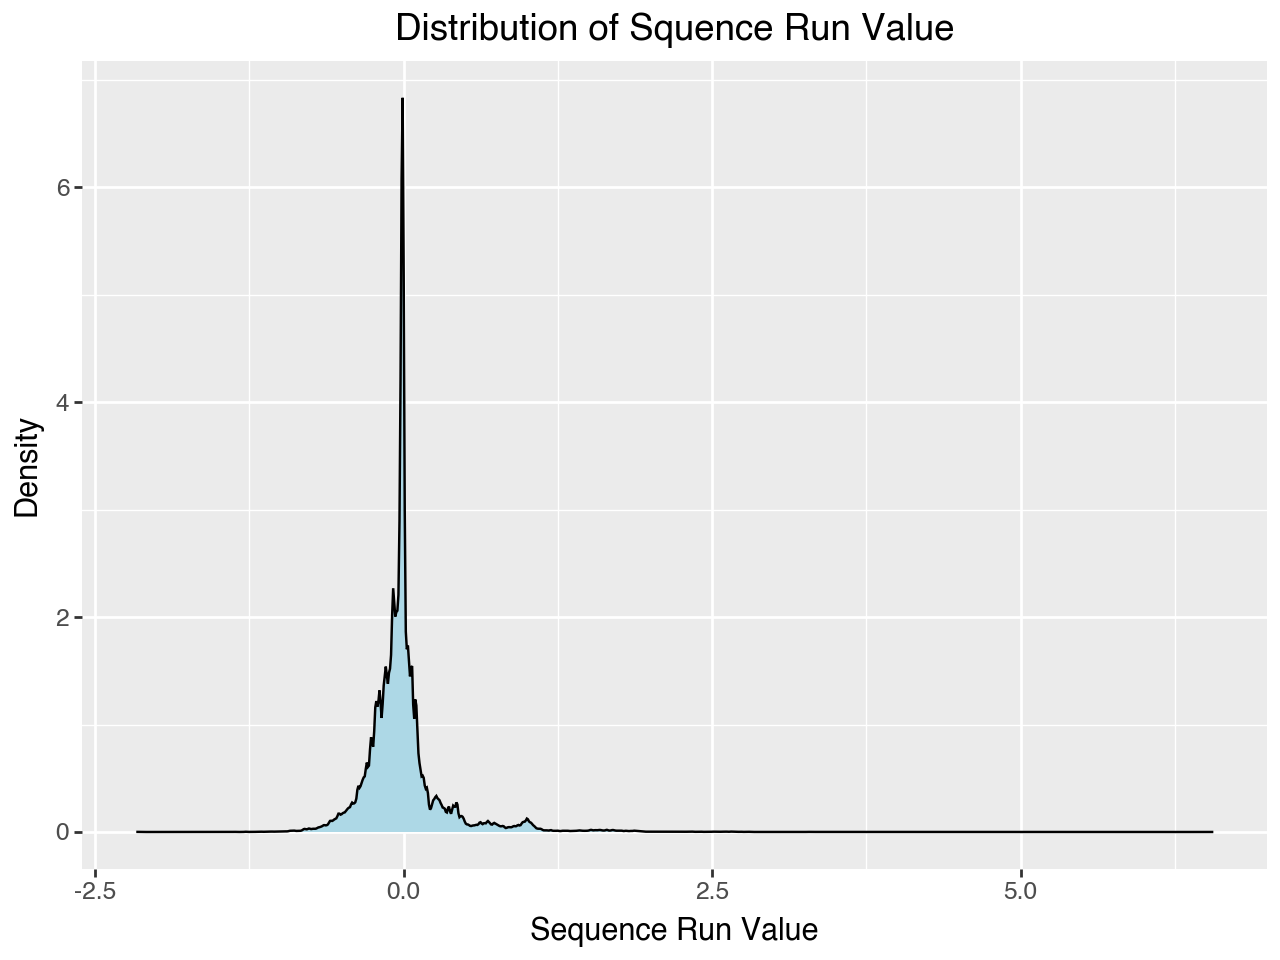

In [16]:
response_dist_plot = (
    ggplot(two_seqs_df.select(RESPONSE), aes(x=RESPONSE))
    + geom_density(fill="lightblue", adjust=1)
    + labs(
        title="Distribution of Squence Run Value",
        x="Sequence Run Value",
        y="Density"
    )
)

response_dist_plot.show()

In [17]:
X = two_seqs_df.select(pl.exclude(
    RESPONSE,
    "prev_delta_run_exp",
    "delta_run_exp_diff",
))

y = two_seqs_df.select(RESPONSE)

# currently not using this ...
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.to_numpy())
y_scaled = scaler.fit_transform(y.to_numpy())

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled,
    test_size=0.2,
    random_state=42,
)

y_train = y_train.flatten()
y_test = y_test.flatten()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(556376, 97) (139094, 97) (556376,) (139094,)


# Feature Selection & EDA

Here I want to select the features that explain the most variance in `delta_run_exp`, instead of using everything which would probably lead to overfitting. This would also be helpful in making the model simpler.

### Recursive Feature Selection

In [18]:
estimator = LGBMRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

# rfecv.fit(X_scaled, y_scaled)
rfecv.fit(X, y)

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15922
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 97
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15929
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 97
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15925
[LightGBM] [Info] Number of data points in the tr

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15920
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 96
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15919
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 94
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15922
[LightGBM] [Info] Number of data points in the tr

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15918
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 95
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15917
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 93
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15920
[LightGBM] [Info] Number of data points in the tr

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/uti

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15915
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 92
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15916
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 94
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15919
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 94
[LightGBM] [Info] S

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15915
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 92
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15914
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 93
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15917
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 93
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15921
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 93
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15916
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 93
[LightGBM] [Info] S

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15912
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 92
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15913
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 91
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15915
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 92
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15914
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 92
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15913
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 91
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15910
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 91
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15913
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 91
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15912
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 91
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15917
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 91
[LightGBM] [Info] S

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15911
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 90
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15908
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 90
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15911
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 90
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15909
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 89
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15906
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 89
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15909
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 89
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15908
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 89
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15913
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 89
[LightGBM] [Info] S

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15907
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 88
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15904
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 88
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15907
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 88
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15906
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 88
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15911
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 88
[LightGBM] [Info] S

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15905
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 87
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15902
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 87
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15905
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 87
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15904
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 87
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15909
[LightGBM] [Info] Number of data points in the tr

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15903
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 86
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15900
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 86
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15903
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 86
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15902
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 86
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15907
[LightGBM] [Info] Number of data points in the tr

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15901
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 85
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15898
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 85
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15901
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 85
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15900
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 85
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15905
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 85
[LightGBM] [Info] S

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15899
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 84
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15896
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 84
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15899
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 84
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15898
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 84
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15897
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 83
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15894
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 83
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15896
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 83
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15897
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 83
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15901
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 83
[LightGBM] [Info] S

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15895
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 82
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15892
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 82
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15894
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 82
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15895
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 82
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15899
[LightGBM] [Info] Number of data points in the tr

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15893
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 81
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15890
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 81
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15892
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 81
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15893
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 81
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15897
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 81
[LightGBM] [Info] S

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15891
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 80
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15888
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 80
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15890
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 80
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15891
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 80
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15889
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 79
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15886
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 79
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15888
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 79
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15889
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 79
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15893
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 79
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15887
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 78
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15884
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 78
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15886
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 78
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15891
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 78
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15887
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 78
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15885
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 77
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15882
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 77
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15884
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 77
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15885
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 77
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15889
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 77
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15883
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 76
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15880
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 76
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15882
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 76
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15630
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 76
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15887
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 76
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15881
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 75
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15878
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 75
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15880
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 75
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15628
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 75
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15885
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 75
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15879
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 74
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15878
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 74
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15876
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 74
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15626
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 74
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15883
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 74
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15877
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 73
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15876
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 73
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15874
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 73
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15624
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 73
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15881
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 73
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15875
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 72
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15874
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 72
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15872
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 72
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15622
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 72
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15879
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 72
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15620
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 71
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15872
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 71
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15870
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 71
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15620
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 71
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15877
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 71
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15618
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 70
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15870
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 70
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15868
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 70
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15618
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 70
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15875
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 70
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15616
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 69
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15615
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 69
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15866
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 69
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15616
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 69
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15614
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 68
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15613
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 68
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15864
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 68
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15614
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 68
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15871
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 68
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15612
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 67
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15611
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 67
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15359
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 67
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15862
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 67
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15869
[LightGBM] [Info] Number of data points in the tr

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15609
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 66
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15610
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 66
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15357
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 66
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15860
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 66
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15614
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 66
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15607
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 65
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15608
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 65
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15355
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 65
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15605
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 65
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15612
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 65
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15352
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 64
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15353
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 64
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15353
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 64
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15350
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 64
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15357
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 64
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15350
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 63
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15098
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 63
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15098
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 63
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15095
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 63
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15355
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 63
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15095
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 62
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15096
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 62
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14843
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 62
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14840
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 62
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15100
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 62
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14840
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 61
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14841
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 61
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14588
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 61
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14838
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 61
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14845
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 61
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14585
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 60
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14586
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 60
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14586
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 60
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14583
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 60
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14590
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 60
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14330
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 59
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14331
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 59
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14331
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 59
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14328
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 59
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14335
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 59
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14075
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 58
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14076
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 58
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14076
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 58
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14080
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 58
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14073
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 58
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13820
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 57
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13821
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 57
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14049
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 57
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13825
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 57
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13818
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 57
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13565
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 56
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13566
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 56
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13794
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 56
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13570
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 56
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13563
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 56
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13538
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 55
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13311
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 55
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13539
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 55
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13315
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 55
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 55
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13283
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 54
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13056
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 54
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13284
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 54
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13288
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 54
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13053
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 54
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13028
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 53
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12801
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 53
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13029
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 53
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13033
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 53
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13026
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 53
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12773
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 52
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12774
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 52
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12774
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 52
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12778
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 52
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12771
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 52
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12518
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 51
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12519
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 51
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12519
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 51
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12523
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 51
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12516
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 51
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12263
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 50
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12264
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 50
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12264
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 50
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12268
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 50
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12261
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 50
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12009
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 49
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12009
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 49
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12013
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 49
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12006
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 49
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11753
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 48
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11754
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 48
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11754
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 48
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11758
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 48
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11498
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 47
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11751
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 48
[LightGBM

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11499
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 47
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11499
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 47
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11503
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 47
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11243
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 46
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11496
[LightGBM] [Info] Number of data points in the tr

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11244
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 46
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11244
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 46
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11248
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 46
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10988
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 45
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11241
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 46
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10989
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 45
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10989
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 45
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10993
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 45
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10733
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 44
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10986
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 45
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10734
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 44
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10734
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 44
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10738
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 44
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10478
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 43
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10731
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 44
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10479
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 43
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10479
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 43
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10483
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 43
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10223
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 42
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10224
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 42
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10476
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 43
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10224
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 42
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10228
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 42
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9968
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 41
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9969
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 41
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10221
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 42
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9969
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 41
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9973
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 41
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9713
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 40
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9714
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 40
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9966
[LightGBM] [Info] Number of data points in the train

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9714
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 40
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9718
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 40
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9458
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9711
[LightGBM] [Info] Number of data points in the train

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9463
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 38
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 38
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9456
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 39
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 38
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9208
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 38
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8948
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 37
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8949
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 37
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9201
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 38
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8949
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 37
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8953
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 37
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8693
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 36
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8694
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 36
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8946
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 37
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8694
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 36
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8698
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 36
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8439
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 35
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8438
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 35
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8691
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 36
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8439
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 35
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8443
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 35
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8184
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 34
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8436
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 35
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8184
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 34
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8188
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 34
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7929
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Total Bins 7928
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8181
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 34
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7929
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7674
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7933
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7673
[LightGBM] [Info] Number of data points in the train

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7926
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 33
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7674
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7419
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7678
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7418
[LightGBM] [Info] Number of data points in the train

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7671
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 32
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7419
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7164
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 30
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7163
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 30
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7423
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7416
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 31
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7164
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 30
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6909
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6908
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7168
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 30
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7161
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 30
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6909
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6894
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6654
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6913
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6906
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 29
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6654
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6639
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6399
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6658
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6651
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 28
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6399
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6144
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6384
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6396
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 27
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5889
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 25
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6370
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 25
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6148
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6141
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 26
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6130
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 25
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5634
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 24
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6115
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 24
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5893
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 25
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5886
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 25
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5875
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 24
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5620
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 23
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5860
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 23
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5879
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 24
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5631
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 24
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5620
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 23
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5365
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5624
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 23
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5376
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 23
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5365
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5110
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5350
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5369
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5362
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 22
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5110
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5107
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 21
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4841
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4840
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4852
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 20
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4841
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4585
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4597
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 19
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4331
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4330
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4583
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 18
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4328
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 17
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3821
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Start training from score -0.002402

[LightGBM] [Info] Total Bins 3820
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4073
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 16
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3818
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 15
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3563
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 14
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3308
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 13
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 12
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 11
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 10
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 7
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 9
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 7
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 8
[LightGBM] [Info] Start training from score -0.001384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 7
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score -0.002402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 7
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score -0.001461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score -0.001918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 6
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 5
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 4
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score -0.001520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score -0.001918


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score -0.002402


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 3
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score -0.001461


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 2
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score -0.001520


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 556376, number of used features: 1
[LightGBM] [Info] Start training from score -0.001384


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15928
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 97
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15926
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 96
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15924
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 95
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15922
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 94
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15920
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 93
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15918
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 92
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15916
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 91
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15914
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 90
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15912
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 89
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15910
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 88
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15908
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 87
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15906
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 86
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15904
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 85
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15902
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 84
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15900
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 83
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15898
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 82
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15896
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 81
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15894
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 80
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15892
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 79
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15890
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 78
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15888
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 77
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15886
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 76
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15884
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 75
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15882
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 74
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15880
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 73
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15878
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 72
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15876
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 71
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15874
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 70
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15619
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 69
[LightGBM] [Info] Start training from score -0.001737


/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15619
[LightGBM] [Info] Number of data points in the train set: 695470, number of used features: 69
[LightGBM] [Info] Start training from score -0.001737


RFECV(cv=5, estimator=LGBMRegressor(n_jobs=-1, random_state=42), n_jobs=-1,
      scoring='neg_mean_absolute_error')

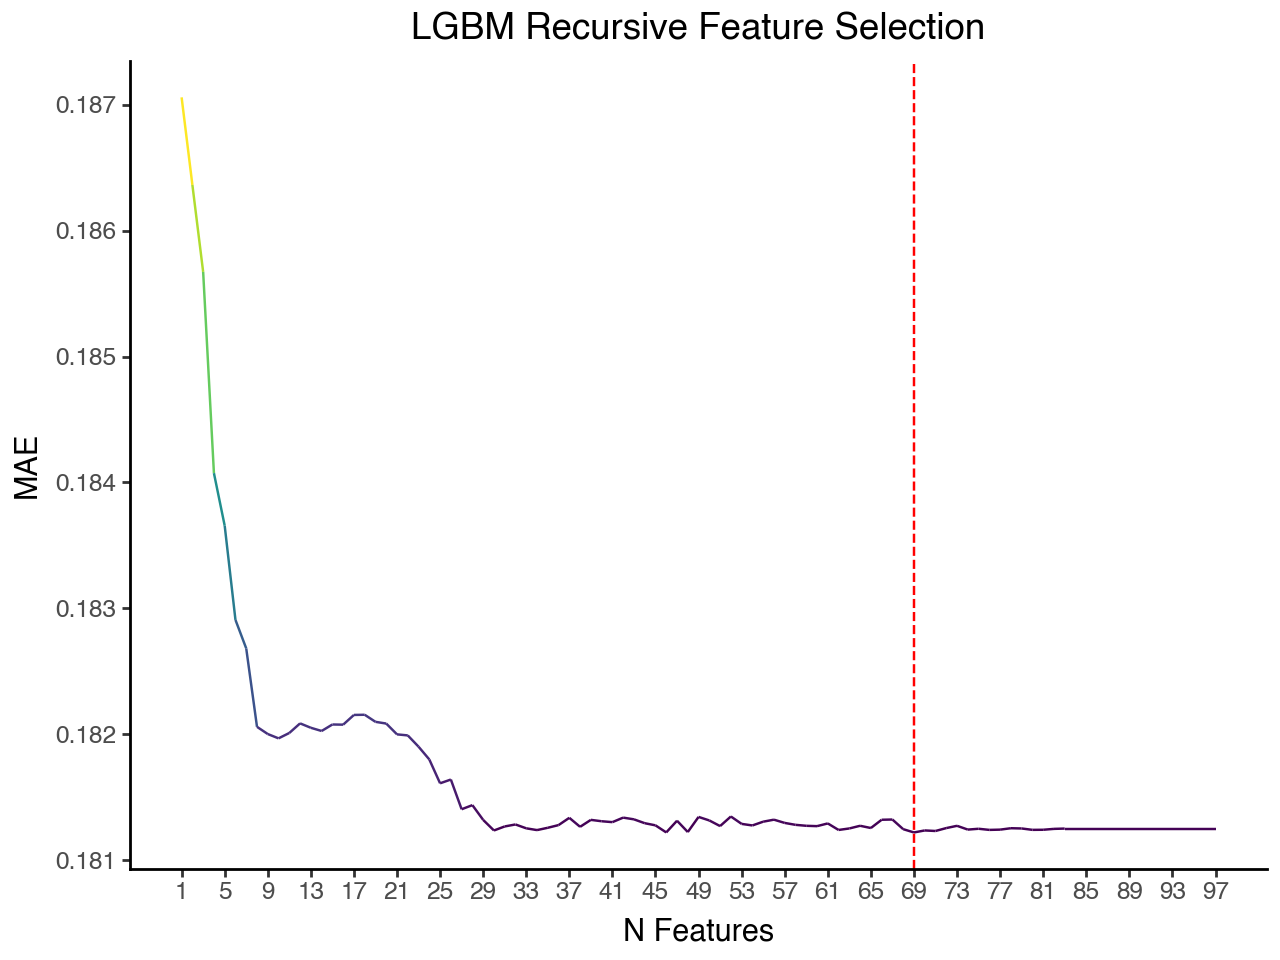

In [19]:
rfecv_plot = (
    ggplot(
        pl.from_dict({
            "N Features": range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
            "MAE": (-rfecv.cv_results_["mean_test_score"]).tolist(),
        }),
        aes(x="N Features", y="MAE", color="MAE"),
    )
    + geom_line()
    + geom_vline(xintercept=rfecv.n_features_,
                 color="red",
                 linetype="dashed")
    + theme_classic()
    + scale_x_continuous(breaks=range(1, len(rfecv.cv_results_["mean_test_score"]) + 1, 4))
    + guides(color="none")
    + labs(title="LGBM Recursive Feature Selection")
)

rfecv_plot.show()

I am going to go with the first elbow around 9. While it does get better after adding lots more features than 9, it becomes really complex and only drops ~0.005 MAE

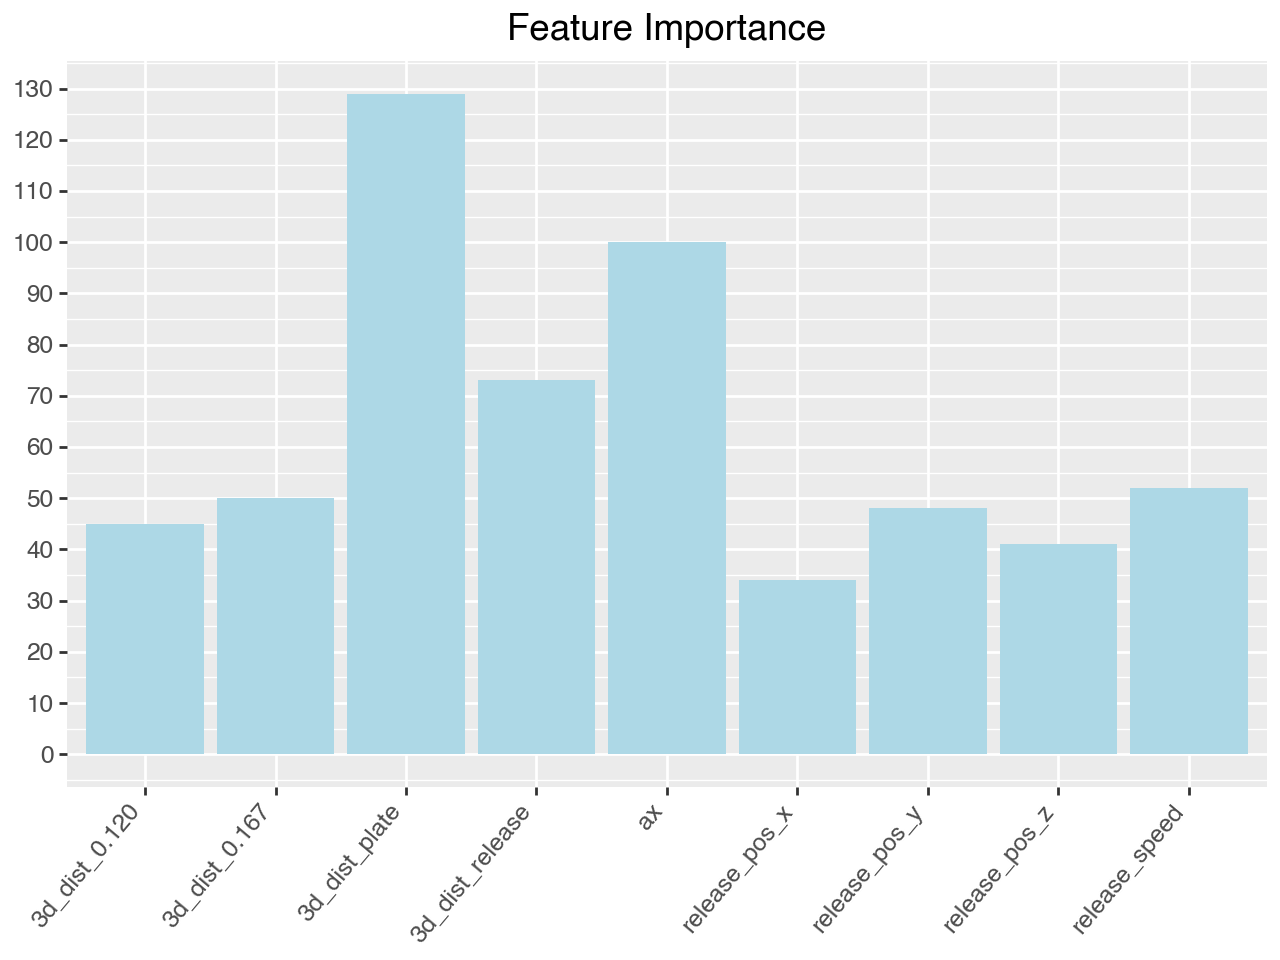

In [20]:
selected_feature_mask = np.where(rfecv.support_)[0]
SELECTED_FEATURES = [X.columns[i] for i in selected_feature_mask[:9]]
feature_importances = rfecv.estimator_.feature_importances_[:9]

feature_importance_plot = (
    ggplot(
        pl.from_dict({
            "Feature": SELECTED_FEATURES,
            "RFECV Importance": feature_importances,
        }),
        aes(x="Feature", y="RFECV Importance"),
    )
    + geom_col(stat="identity", fill="lightblue")
    + theme(axis_text_x=element_text(rotation=50, hjust=1))
    + scale_y_continuous(breaks=range(0, max(feature_importances) + 10, 10))
    + labs(title="Feature Importance", x="", y="")
)

feature_importance_plot.show()

### EDA

Visualizing the selected features

In [21]:
sample_pitches_df = (two_seqs_df
                     .select(*SELECTED_FEATURES, RESPONSE)
                     .sample(10_000))

sample_pitches_df.sample(5, seed=42)

release_speed,release_pos_x,release_pos_y,release_pos_z,3d_dist_plate,3d_dist_release,3d_dist_0.120,3d_dist_0.167,ax,seq_delta_run_exp
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
80.1,-0.68,4.553333,5.82,2.397077,0.321511,1.785939,2.454537,-7.41592,0.241
90.0,-1.08,4.5175,6.73,0.779322,0.064377,0.420779,0.562027,7.089898,0.477
87.4,-1.65,4.470833,6.26,2.741972,0.271264,1.228776,1.699708,3.367654,-0.153
83.3,-1.7,4.55,6.37,3.002412,0.380821,0.917997,1.29235,-4.90218,0.036
83.1,-1.39,4.54,6.03,0.570444,0.205388,1.614133,2.230958,10.94939,1.003


### Relationship Matrix

Each plot shows the relationship between a feature, and `delta_run_exp`

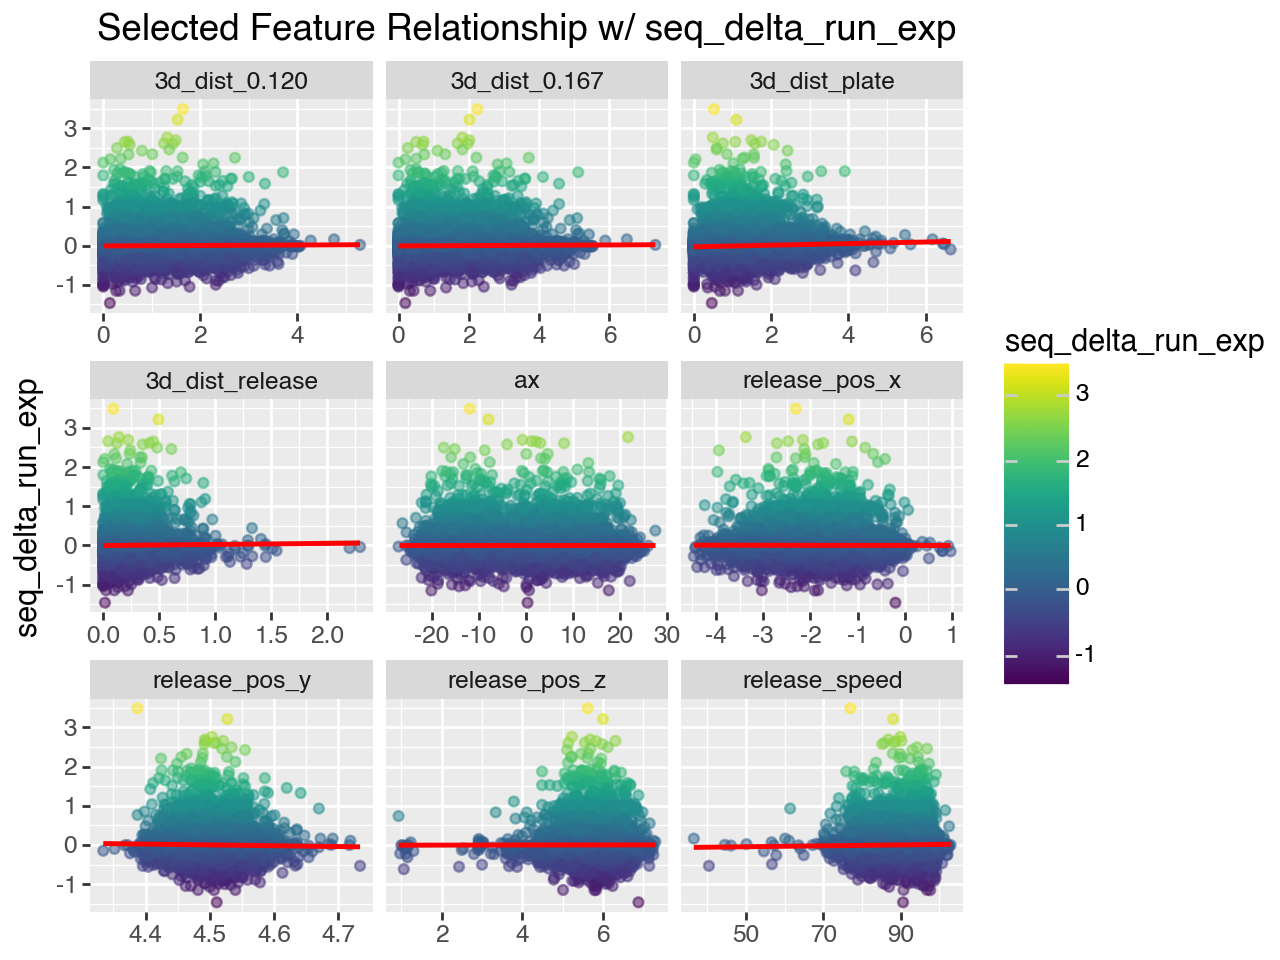

In [22]:
rel_matrix = (
    ggplot(sample_pitches_df.unpivot(index=RESPONSE, on=SELECTED_FEATURES),
           aes(x="value", y="seq_delta_run_exp", color="seq_delta_run_exp"))
    + geom_point(alpha=0.5)
    + geom_smooth(color="red")
    + facet_wrap("~ variable", scales="free_x")
    # + theme_linedraw()
    + labs(
        title="Selected Feature Relationship w/ seq_delta_run_exp",
        x="",
    )
)

rel_matrix.show()

### Correlation Matrix

Each chunk represents the pearson correlation coefficient between two features

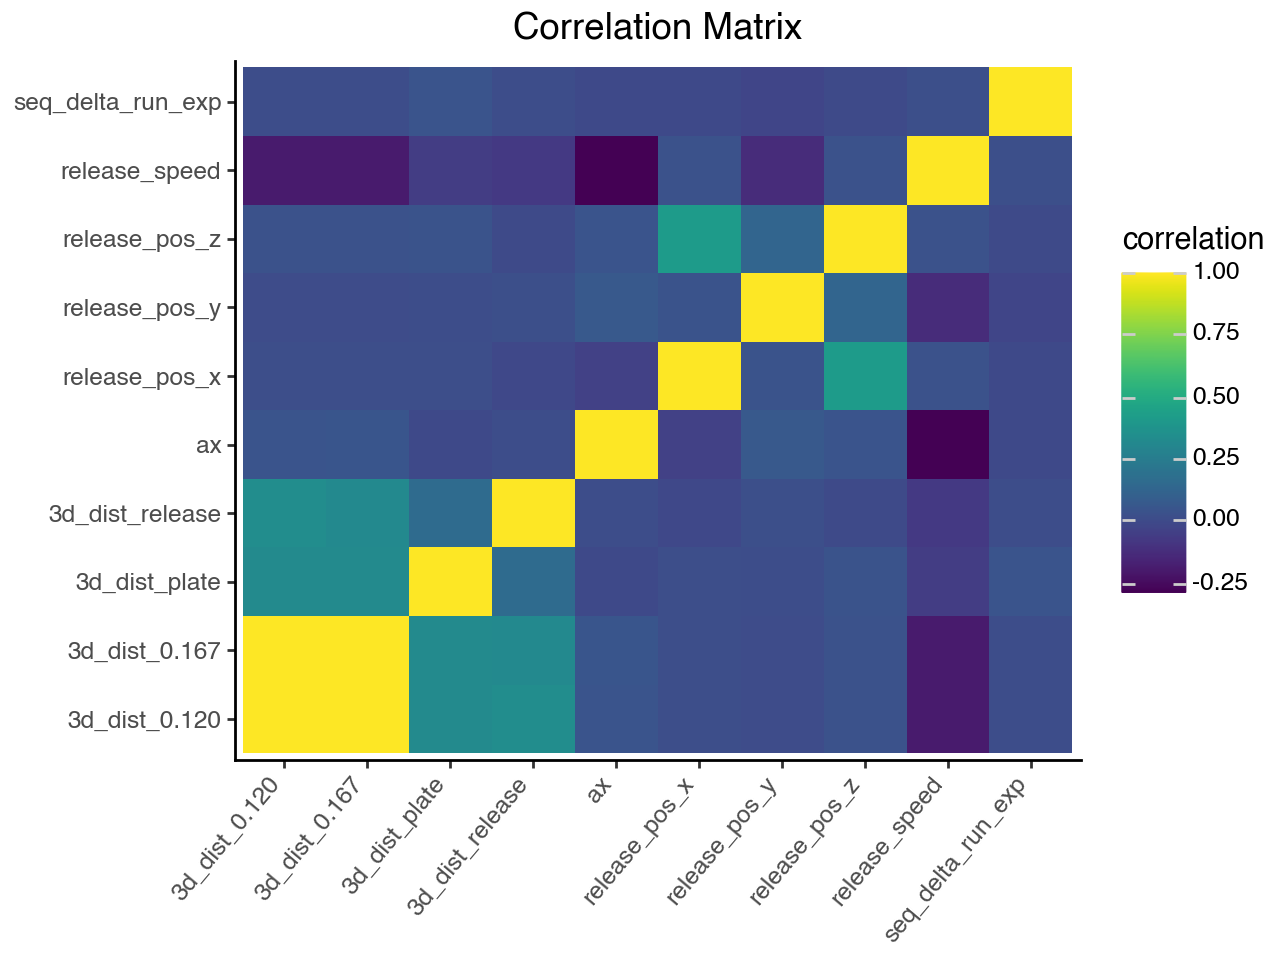

In [23]:
sample_corr_df = sample_pitches_df.corr()

corr_matrix = (
    ggplot(
        sample_corr_df
        .with_columns(pl.Series("variable_1", sample_corr_df.columns))
        .unpivot(
            index="variable_1",
            variable_name="variable_2",
            on=sample_corr_df.columns,
            value_name="correlation",
        ),
        aes(x="variable_1", y="variable_2", fill="correlation"),
    )
    + geom_tile(size=3)
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=50, hjust=1))
    + labs(
        title="Correlation Matrix",
        x="",
        y="",
    )
)

corr_matrix.show()